In [8]:
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
import argparse
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import warnings
from timeit import default_timer as timer
warnings.simplefilter('ignore')
from tqdm.notebook import tqdm

In [9]:
#Test
class MyTestSet(Dataset):
    def __init__(self, img):
        self.img = np.load(img)
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        return img
    def __len__(self):
        return self.img.shape[0]

In [10]:
test = MyTestSet("test_pre.npy")
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [11]:
file = open("label_encoder_pre.obj",'rb')
le = pickle.load(file)
file.close()
trainy = pd.read_csv("trainy_pre.csv")
classes = len(np.unique(trainy['celltype_l2']))

In [12]:
mod = EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
# mod =EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#     mod = nn.DataParallel(mod)

# torch.cuda.is_available()
# torch.cuda.device_count()
# torch.cuda.current_device()
# torch.cuda.get_device_name()

mod.to(device)
mod = mod.to(device)
mod.load_state_dict(torch.load(("checkpoint_model_pre.pth")))
mod.eval()

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [13]:
out = []
start_time = time.time()

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc="Running inference"):
        query = data.to(device)
        pred = mod(query)
        _, predicted = torch.max(pred.data, 1)
        out.append(predicted)

end_time = time.time()
print(f"Inference completed in {(end_time - start_time)/60:.2f} minutes")
pred = torch.cat(out, dim=0)
pr = pred.cpu().numpy()


# out = []
# for i, data in enumerate(test_loader):
#     query = data
#     query = query.to(device)
#     pred= mod(query)
#     _, predicted = torch.max(pred.data, 1)
#     out.append(predicted)

# pred = torch.cat(out, dim=0)
# pr = pred.cpu().numpy()

Running inference:   0%|          | 0/1174 [00:00<?, ?it/s]

Inference completed in 3.50 minutes


In [14]:
real_label = pd.read_csv("testy_pre.csv", index_col=0)
real_label.value_counts()

celltype_l2  
Monocytes        14054
Endothelial       6246
FAPs              5436
Macrophages       2140
Myonuclei         1726
T Cells           1668
Dendritic         1525
MuSCs             1227
Neutrophils        907
Smooth Muscle      731
NK Cells           604
Tenocytes          504
Neural             404
B Cells            206
Myoblasts          163
Name: count, dtype: int64

In [15]:
file = open("label_encoder_pre.obj",'rb')
le = pickle.load(file)
file.close()
pred_label = le.inverse_transform(pr)
pred_label = pd.DataFrame(pred_label)
pred_label.value_counts()

0            
Monocytes        13899
Endothelial       6231
FAPs              5474
Macrophages       2193
Myonuclei         1705
Dendritic         1700
T Cells           1669
MuSCs             1181
Neutrophils        894
Smooth Muscle      728
NK Cells           611
Tenocytes          488
Neural             407
B Cells            183
Myoblasts          178
Name: count, dtype: int64

In [16]:
ls = list(set(pd.unique(pred_label[0]).tolist()) | set(pd.unique(real_label["celltype_l2"]).tolist()))
acc = accuracy_score(pred_label,real_label)

le2 = preprocessing.LabelEncoder()
le2.fit(ls)
pred_label_2 = le2.transform(pred_label[0])
real_label_2 = le2.transform(real_label["celltype_l2"])
ari = adjusted_rand_score(real_label_2, pred_label_2)

print("Accuray: %.03f, ARI = %.03f" % (acc, ari))

Accuray: 0.943, ARI = 0.879


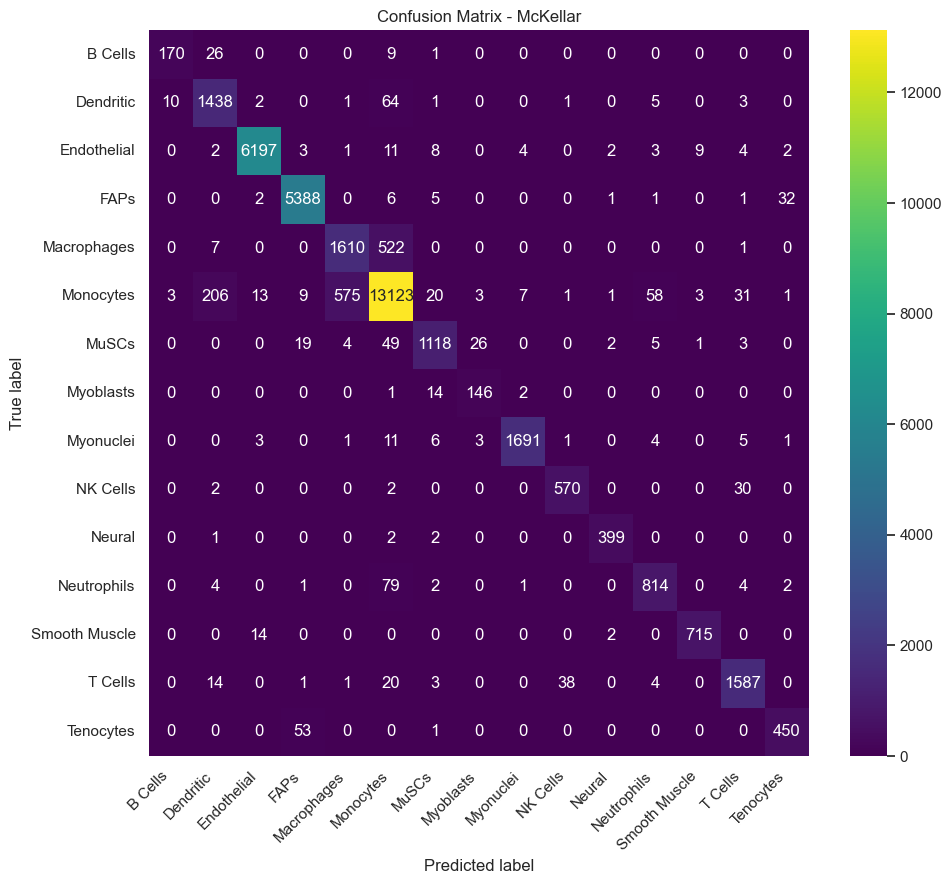

In [33]:
# Combine unique labels from both prediction and truth
import seaborn as sns
from sklearn.metrics import confusion_matrix
le2 = preprocessing.LabelEncoder()
all_labels = list(set(pred_label[0]) | set(real_label["celltype_l2"]))
le2.fit(all_labels)

y_pred = le2.transform(pred_label[0])
y_true = le2.transform(real_label["celltype_l2"])

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = le2.classes_

plt.figure(figsize=(10, 9))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names, cbar=True)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - McKellar")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Generating softmax scores: 100%|██████████| 1174/1174 [03:37<00:00,  5.39it/s]


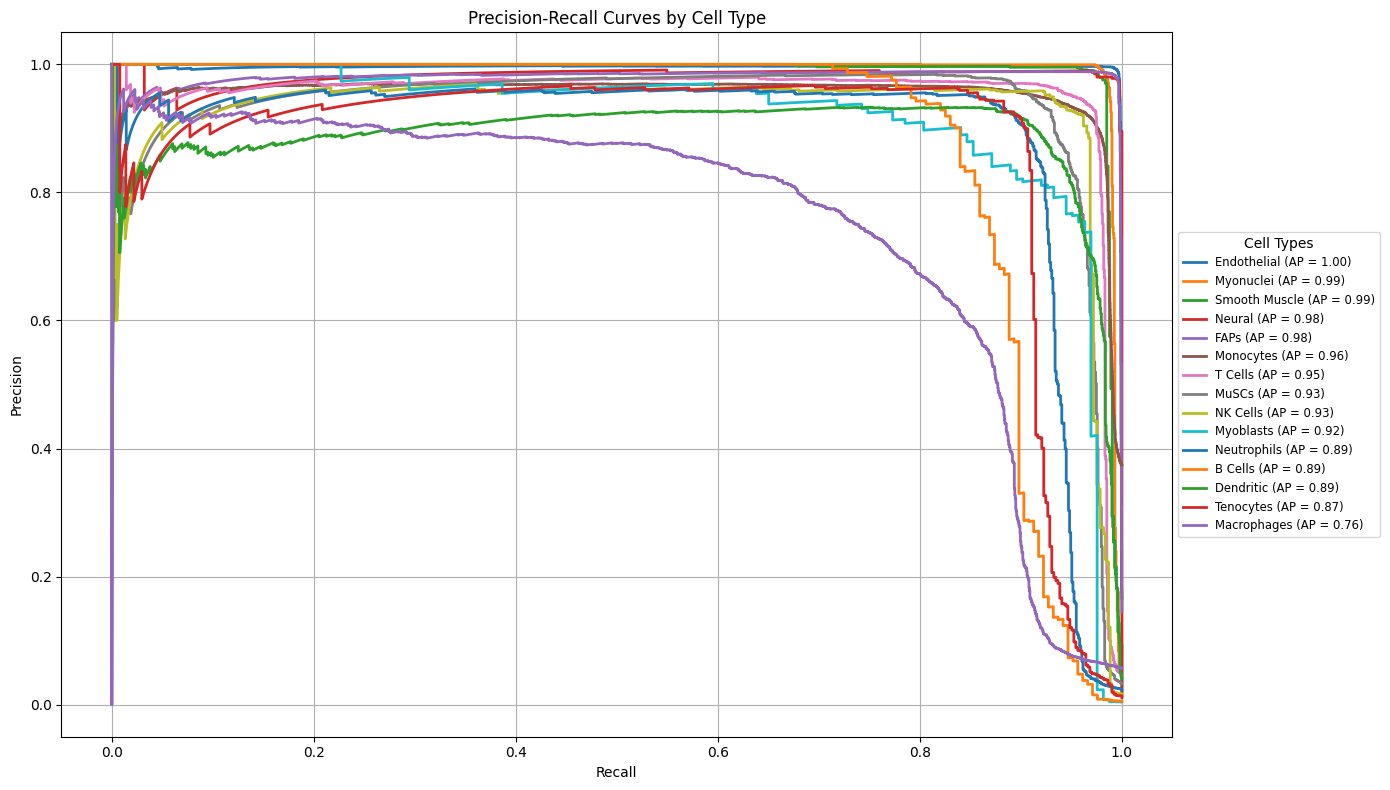

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
from tqdm import tqdm

# ----------------------------
# STEP 1 — Re-run inference to get probabilities
# ----------------------------
model = mod  # make sure your trained model is assigned to `mod`
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for images in tqdm(test_loader, desc="Generating softmax scores"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

# Combine all predicted probabilities
y_scores = np.vstack(all_probs)

# Get true labels from your metadata
from sklearn.preprocessing import LabelEncoder
real_label_array = real_label["celltype_l2"].values
le = LabelEncoder()
y_true = le.fit_transform(real_label_array)

# ----------------------------
# STEP 2 — Encode labels
# ----------------------------
y_true_encoded = le.fit_transform(real_label["celltype_l2"])
class_names = le.classes_  # This will contain real cell type names like 'T cells', 'Macrophages', etc.

n_classes = len(class_names)

# Binarize true labels for PR curve
y_true_bin = label_binarize(y_true_encoded, classes=range(n_classes))

# ----------------------------
# STEP 3 — Compute and plot PR curves
# ----------------------------
precision = {}
recall = {}
average_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_scores[:, i])

# Plot PR curves
plt.figure(figsize=(14, 8))

# Sort classes by average precision
sorted_indices = sorted(average_precision, key=average_precision.get, reverse=True)

for i in sorted_indices:
    celltype = class_names[i]
    ap = average_precision[i]
    plt.plot(recall[i], precision[i], lw=2, label=f"{celltype} (AP = {ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves by Cell Type")
plt.grid(True)

# Place legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small', title="Cell Types")
plt.tight_layout()
plt.show()


In [19]:
# Compute TP, FP, FN, TN per class
tp = np.diag(cm)
fp = np.sum(cm, axis=0) - tp
fn = np.sum(cm, axis=1) - tp
tn = cm.sum() - (tp + fp + fn)

# Create DataFrame
metrics_df = pd.DataFrame({
    'type': class_names,
    'TP': tp,
    'FP': fp,
    'FN': fn,
    'TN': tn
})

# Optional: sort by class or any metric
metrics_df = metrics_df.sort_values(by='type').reset_index(drop=True)
display(metrics_df)

,type,TP,FP,FN,TN
0,B Cells,170,13,36,37322
1,Dendritic,1438,262,87,35754
2,Endothelial,6197,34,49,31261
3,FAPs,5388,86,48,32019
4,Macrophages,1610,583,530,34818
5,Monocytes,13123,776,931,22711
6,MuSCs,1118,63,109,36251
7,Myoblasts,146,32,17,37346
8,Myonuclei,1691,14,35,35801
9,NK Cells,570,41,34,36896


In [20]:
from sklearn.metrics import classification_report

# Make sure both predicted and true labels are in the same format
y_true = real_label["celltype_l2"]
y_pred = pred_label[0]  # assuming pred_label is a DataFrame

# Generate the classification report
print(classification_report(real_label_2, pred_label_2, target_names=le.classes_, digits=8))

               precision    recall  f1-score   support

      B Cells  0.92896175 0.82524272 0.87403599       206
    Dendritic  0.84588235 0.94295082 0.89178295      1525
  Endothelial  0.99454341 0.99215498 0.99334776      6246
         FAPs  0.98428937 0.99116998 0.98771769      5436
  Macrophages  0.73415413 0.75233645 0.74313409      2140
    Monocytes  0.94416865 0.93375551 0.93893321     14054
        MuSCs  0.94665538 0.91116544 0.92857143      1227
    Myoblasts  0.82022472 0.89570552 0.85630499       163
    Myonuclei  0.99178886 0.97972190 0.98571845      1726
     NK Cells  0.93289689 0.94370861 0.93827160       604
       Neural  0.98034398 0.98762376 0.98397041       404
  Neutrophils  0.91051454 0.89746417 0.90394225       907
Smooth Muscle  0.98214286 0.97811218 0.98012337       731
      T Cells  0.95086878 0.95143885 0.95115373      1668
    Tenocytes  0.92213115 0.89285714 0.90725806       504

     accuracy                      0.94339522     37541
    macro avg  0.

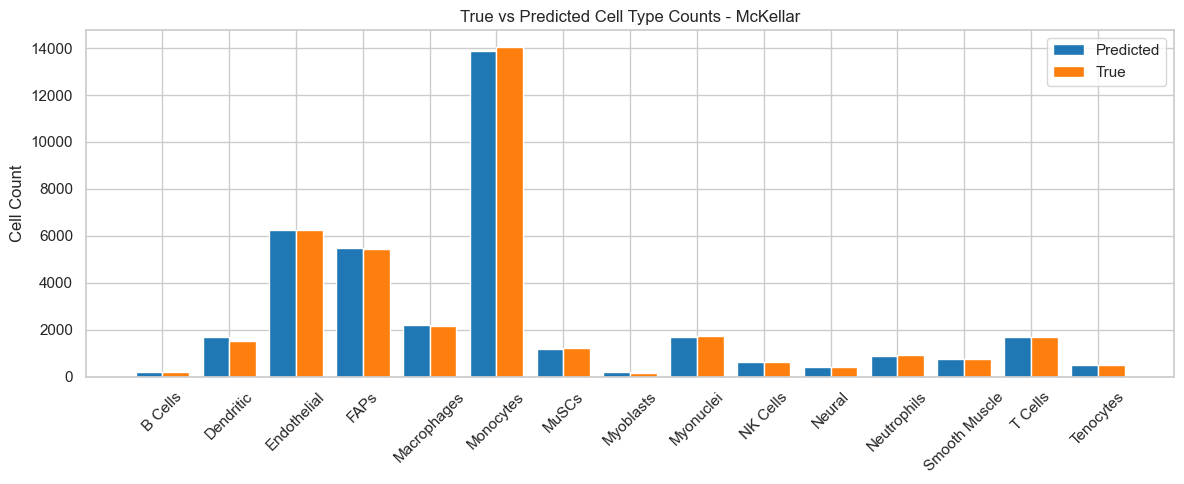

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Optional: set a clean style
sns.set(style="whitegrid")

# Count predicted and true labels
pred_counts = pred_label[0].value_counts().sort_index()
true_counts = real_label["celltype_l2"].value_counts().reindex(pred_counts.index)

# Generate positions
indices = np.arange(len(pred_counts))
bar_width = 0.4

# Choose visually distinct colors
pred_color = '#1f77b4'  # blue
true_color = '#ff7f0e'  # orange

# Plot
plt.figure(figsize=(12, 5))
plt.bar(indices, pred_counts.values, width=bar_width, label='Predicted', color=pred_color)
plt.bar(indices + bar_width, true_counts.values, width=bar_width, label='True', color=true_color)

# Fix labels
plt.xticks(indices + bar_width / 2, pred_counts.index, rotation=45)
plt.ylabel("Cell Count")
plt.title("True vs Predicted Cell Type Counts - McKellar")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
import torch.nn.functional as nnf
pros = []
with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc="Running inference"):
        query = data
        query = query.to(device)
        pred = mod(query)
        p = nnf.softmax(pred.data).cpu()
        pros.append(p)

Running inference: 100%|██████████| 1174/1174 [03:41<00:00,  5.30it/s]


In [23]:
prob = torch.cat(pros, dim=0)
prob

tensor([[0.0067, 0.0068, 0.0076,  ..., 0.0065, 0.0068, 0.0069],
        [0.0066, 0.0071, 0.0063,  ..., 0.0068, 0.0067, 0.0065],
        [0.0069, 0.0067, 0.0061,  ..., 0.0068, 0.0069, 0.0067],
        ...,
        [0.0065, 0.0067, 0.9078,  ..., 0.0061, 0.0066, 0.0068],
        [0.0070, 0.0070, 0.8995,  ..., 0.0069, 0.0073, 0.0069],
        [0.0066, 0.0070, 0.0066,  ..., 0.0067, 0.0069, 0.0070]])

In [24]:
max_prob, predicted_classes = torch.max(prob, axis=1)
max_prob

tensor([0.9055, 0.9081, 0.9051,  ..., 0.9078, 0.8995, 0.9057])

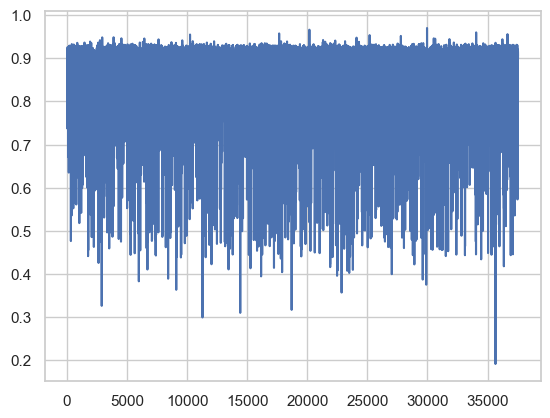

In [25]:
plt.plot(max_prob)

<Axes: ylabel='Density'>

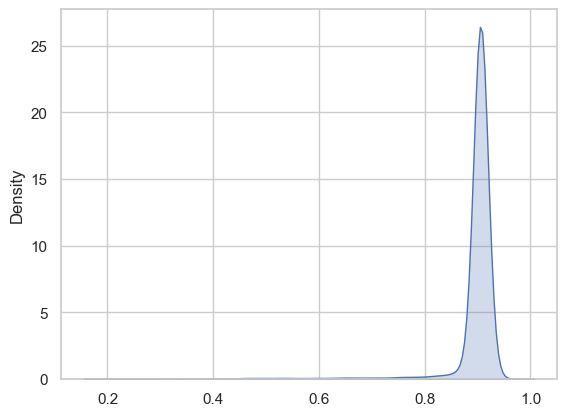

In [26]:
import seaborn as sns
sns.kdeplot(max_prob, bw_adjust=2, fill=True)

In [27]:
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(real_label_2, prob, multi_class='ovr')
print("AUROC: %.03f" % auroc)

AUROC: 0.984


In [28]:
from torchmetrics.classification import AveragePrecision
average_precision = AveragePrecision(task="multiclass", num_classes=classes, average="weighted")
aurpc_weighted = average_precision(prob, torch.from_numpy(real_label_2))
print("AURPC (weighted): %.03f" % aurpc_weighted)

AURPC (weighted): 0.950


In [29]:
from torchmetrics.classification import AveragePrecision
average_precision = AveragePrecision(task="multiclass", num_classes=classes, average="macro")
aurpc_macro = average_precision(prob, torch.from_numpy(real_label_2))
print("AURPC (macro): %.03f" % aurpc_macro)

AURPC (macro): 0.929


In [30]:
from sklearn.metrics import f1_score
f1_score(real_label_2, pred_label_2, average=None)

array([0.87403599, 0.89178295, 0.99334776, 0.98771769, 0.74313409,
       0.93893321, 0.92857143, 0.85630499, 0.98571845, 0.9382716 ,
       0.98397041, 0.90394225, 0.98012337, 0.95115373, 0.90725806])

In [31]:
f1_weighted = f1_score(real_label_2, pred_label_2, average='weighted')
print("F1-score(weighted): %.03f" % f1_weighted)

F1-score(weighted): 0.944


In [32]:
f1_macro = f1_score(real_label_2, pred_label_2, average='macro')
print("F1-score(weighted): %.03f" % f1_macro)

F1-score(weighted): 0.924
